# 1. Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pmdarima.arima import auto_arima

In [2]:
data = pd.read_excel('data.xlsx')

In [3]:
data.set_index(pd.to_datetime(data[["YEAR", "MONTH"]].assign(DAY=1)), inplace = True)

In [4]:
data.drop(['YEAR','MONTH','HANSGN'], axis = 1, inplace = True)

In [5]:
data.head(5)

,TTT
2015-01-01,1436819
2015-02-01,1541333
2015-03-01,1680903
2015-04-01,1684774
2015-05-01,1772993


<AxesSubplot:>

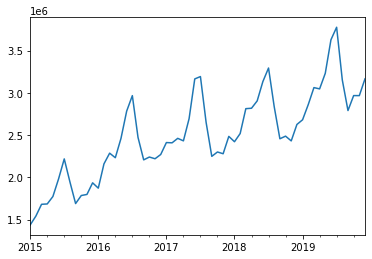

In [6]:
data['TTT'].plot()

In [7]:
train = data[:-12].copy()
test = data[-12:].copy() # last 12 months as test set

In [8]:
test

,TTT
2019-01-01,2680573
2019-02-01,2860436
2019-03-01,3061302
2019-04-01,3045879
2019-05-01,3230488
2019-06-01,3627333
2019-07-01,3775263
2019-08-01,3151724
2019-09-01,2789760
2019-10-01,2966733


# 2. Time Series Analysis

In [9]:
# Stationarity test:
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -3.968342
Critical Values at 0.05: -2.94
p-value: 0.001586
Stationary


In [10]:
kpss_test = kpss(train)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.795515
Critical Values at 0.05: 0.46
p-value: 0.010000
Not stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


<AxesSubplot:>

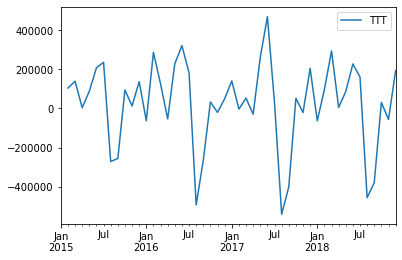

In [11]:
train1 = train - train.shift(1)
train1.plot()

In [12]:
# unit-root ("difference stationary") test:
# Difference-stationary: If a time series can be made stationary by differencing, it is said to contain a unit root.
# In essence, this means that the current value of a series yt is equal to its last value yt−1 plus an error ϵt
# i.e. yt=ayt−1+ϵt with |a|=1
# Variables that show this behaviour are also said to be integrated of order d, or I(d)
# which means that d differences are neccesary to render a series stationary.
result = adfuller(train1.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -6.515841
p-value: 0.000000
Stationary


In [13]:
# trend-stationary test:
kpss_test = kpss(train1.dropna())

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.071539
Critical Values @ 0.05: 0.46
p-value: 0.100000
Stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


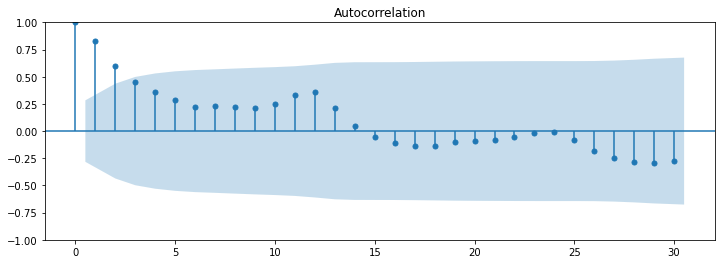

In [14]:
# Check ACF and PACF:
plt.figure(figsize=(12,4))
plot_acf(train, ax=plt.gca(), lags = 30)
plt.show()

C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


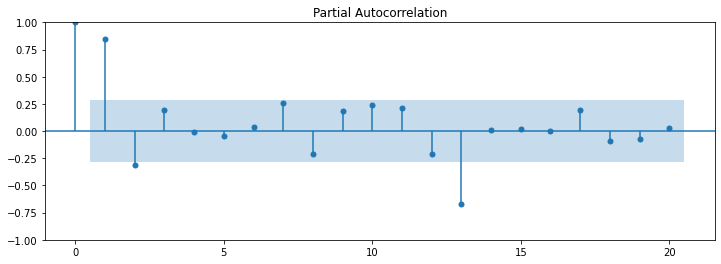

In [15]:
plt.figure(figsize=(12,4))
plot_pacf(train, ax=plt.gca(), lags = 20)
plt.show()

Conclusion:
- Because the time series is stationary after 1 differencing, d value should be 1
- Based on ACF plot, q value should be 3
- Based on PACF plot, p value should be 1

# 3. Build models

## 3.1. ARIMA without boxcox

In [16]:
model = auto_arima(train,
                   d = 3,
                   start_p = 0,
                   max_p = 13,
                   start_q = 0,
                   max_q = 2,
                   m = 12,
                   seasonal = True,
                   trace = True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(1,1,1)[12]             : AIC=919.036, Time=0.25 sec
 ARIMA(0,3,0)(0,1,0)[12]             : AIC=935.270, Time=0.02 sec
 ARIMA(1,3,0)(1,1,0)[12]             : AIC=913.656, Time=0.07 sec
 ARIMA(0,3,1)(0,1,1)[12]             : AIC=897.827, Time=0.11 sec
 ARIMA(0,3,1)(0,1,0)[12]             : AIC=902.378, Time=0.05 sec
 ARIMA(0,3,1)(1,1,1)[12]             : AIC=896.241, Time=0.15 sec
 ARIMA(0,3,1)(1,1,0)[12]             : AIC=896.091, Time=0.12 sec
 ARIMA(0,3,1)(2,1,0)[12]             : AIC=896.415, Time=0.29 sec
 ARIMA(0,3,1)(2,1,1)[12]             : AIC=898.237, Time=0.57 sec
 ARIMA(0,3,0)(1,1,0)[12]             : AIC=914.310, Time=0.05 sec
 ARIMA(1,3,1)(1,1,0)[12]             : AIC=897.064, Time=0.12 sec
 ARIMA(0,3,2)(1,1,0)[12]             : AIC=895.532, Time=0.15 sec
 ARIMA(0,3,2)(0,1,0)[12]             : AIC=897.393, Time=0.05 sec
 ARIMA(0,3,2)(2,1,0)[12]             : AIC=896.495, Time=0.36 sec
 ARIMA(0,3,2)(1,1,1)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   48
Model:             SARIMAX(1, 3, 2)x(1, 1, [1], 12)   Log Likelihood                -440.668
Date:                              Fri, 03 Feb 2023   AIC                            893.335
Time:                                      11:34:52   BIC                            902.314
Sample:                                  01-01-2015   HQIC                           896.356
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8223      0.546     -1.506      0.132      -1.892       0.248
ma.L1         -0.1124      0.589     -0.191      0.849      -1.266       1.042
ma.L2         -0.8486      0.536     -1.583      0.113      -1.899       0.202
ar.S.L12      -0.7463      0.651     -1.147      0.251      -2.022       0.529
ma.S.L12       0.6104      0.792      0.771      0.441      -0.941       2.162
sigma2      3.324e+10   1.69e-11   1.96e+21      0.000    3.32e+10    3.32e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.20   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.27   Prob(JB):                         0.97
Heteroskedasticity (H):               1.56   Skew:                            -0.10
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.66e+37. Standard errors may be unstable.
"""

In [17]:
# Predict using the best model from auto_arima:
test['predict'] = pd.Series(model.predict(12).astype('int64'))

In [18]:
test

,TTT,predict
2019-01-01,2680573,2764231
2019-02-01,2860436,2841604
2019-03-01,3061302,3128380
2019-04-01,3045879,3159322
2019-05-01,3230488,3294846
2019-06-01,3627333,3595730
2019-07-01,3775263,3763007
2019-08-01,3151724,3318390
2019-09-01,2789760,2942155
2019-10-01,2966733,3010190


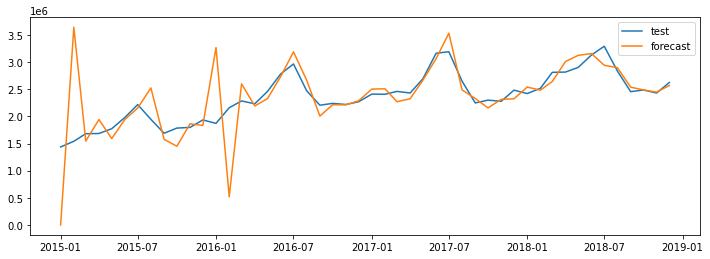

In [19]:
# Plot train vs forecast
plt.figure(figsize=(12,4))
plt.plot(train, label='test')
plt.plot(model.predict_in_sample(), label='forecast')
plt.legend(loc='best')
plt.show()

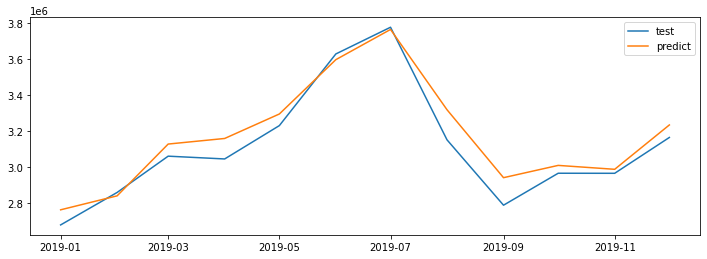

In [20]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(test['TTT'], label='test')
plt.plot(test['predict'], label='predict')
plt.legend(loc='best')
plt.show()

In [21]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(test['TTT'], test['predict'])).round(2)
mape = np.round(np.mean(np.abs(test['TTT']-test['predict'])/test['TTT'])*100,2)

In [22]:
results = pd.DataFrame({'Method':'ARIMA', 'MAPE': [mape], 'RMSE': [rmse]})
results

,Method,MAPE,RMSE
0,ARIMA,2.34,85731.31


## 3.2. ARIMA with boxcox (trend stationary)

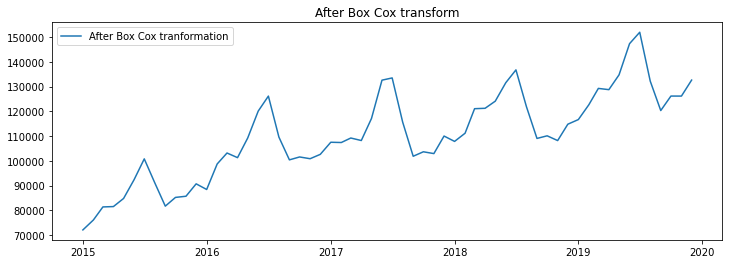

In [23]:
data_boxcox = pd.Series(boxcox(data['TTT'])[0], index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [24]:
# Stationarity test:
result = adfuller(data_boxcox)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -2.315488
Critical Values at 0.05: -2.92
p-value: 0.167021
Not stationary


In [25]:
kpss_test = kpss(data_boxcox)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 1.059631
Critical Values at 0.05: 0.46
p-value: 0.010000
Not stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


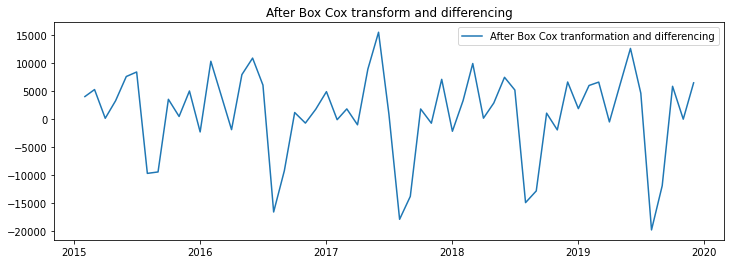

In [26]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(1), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [27]:
data_boxcox_diff.dropna(inplace=True)

In [28]:
# Stationarity test:
result = adfuller(data_boxcox_diff)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -1.697966
Critical Values at 0.05: -2.93
p-value: 0.432161
Not stationary


In [29]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.049471
Critical Values at 0.05: 0.46
p-value: 0.100000
Stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


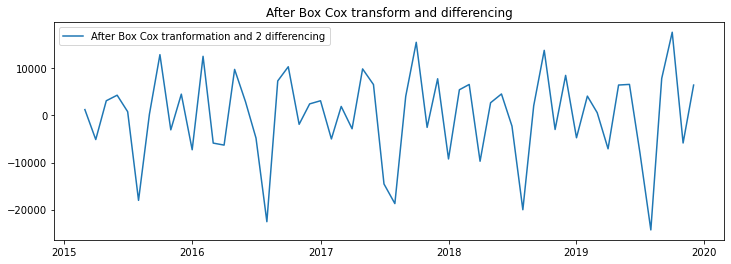

In [30]:
data_boxcox_diff2 = pd.Series(data_boxcox_diff - data_boxcox_diff.shift(1), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff2, label='After Box Cox tranformation and 2 differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [31]:
data_boxcox_diff2.dropna(inplace=True)

In [32]:
# Stationarity test:
result = adfuller(data_boxcox_diff2)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -10.868264
Critical Values at 0.05: -2.93
p-value: 0.000000
Stationary


In [33]:
kpss_test = kpss(data_boxcox_diff2)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if kpss_test[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.362500
Critical Values at 0.05: 0.46
p-value: 0.093319
Stationary


In [34]:
data_boxcox_diff2.tail()

2019-08-01   -24333.806447
2019-09-01     7867.386826
2019-10-01    17698.487960
2019-11-01    -5849.762106
2019-12-01     6464.926196
dtype: float64

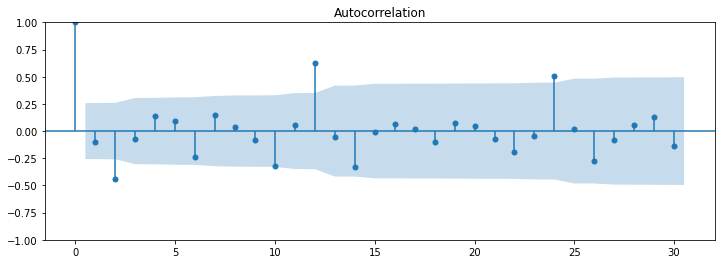

In [35]:
# Check ACF and PACF:
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff2, ax=plt.gca(), lags = 30)
plt.show()

C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


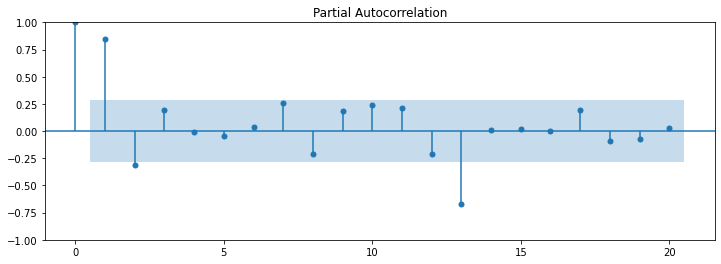

In [36]:
plt.figure(figsize=(12,4))
plot_pacf(train, ax=plt.gca(), lags = 20)
plt.show()

Conclusion:
- Because the time series is stationary after 2 differencing, d value should be 2
- Based on ACF plot, q value should be 0
- Based on PACF plot, p value should be 1

In [37]:
train_data_boxcox_diff = data_boxcox[:-12]
test_data_boxcox_diff = data_boxcox[-12:]

In [38]:
test_data_boxcox_diff

2019-01-01    116659.622426
2019-02-01    122646.749958
2019-03-01    129231.894689
2019-04-01    128729.861157
2019-05-01    134701.756453
2019-06-01    147282.469108
2019-07-01    151889.972178
2019-08-01    132163.668800
2019-09-01    120304.752248
2019-10-01    126144.323656
2019-11-01    126134.132959
2019-12-01    132588.868457
dtype: float64

In [39]:
model = auto_arima(train_data_boxcox_diff,
                   d = 3,
                   start_p = 0,
                   max_p = 13,
                   start_q = 0,
                   max_q = 2,
                   m = 12,
                   seasonal = True,
                   trace = True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(1,1,1)[12]             : AIC=695.283, Time=0.09 sec
 ARIMA(0,3,0)(0,1,0)[12]             : AIC=710.380, Time=0.02 sec
 ARIMA(1,3,0)(1,1,0)[12]             : AIC=690.005, Time=0.06 sec
 ARIMA(0,3,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,3,0)(0,1,0)[12]             : AIC=705.476, Time=0.02 sec
 ARIMA(1,3,0)(2,1,0)[12]             : AIC=689.062, Time=0.19 sec
 ARIMA(1,3,0)(2,1,1)[12]             : AIC=690.734, Time=0.42 sec
 ARIMA(1,3,0)(1,1,1)[12]             : AIC=688.755, Time=0.14 sec
 ARIMA(1,3,0)(0,1,1)[12]             : AIC=693.267, Time=0.07 sec
 ARIMA(1,3,0)(1,1,2)[12]             : AIC=690.730, Time=0.43 sec
 ARIMA(1,3,0)(0,1,2)[12]             : AIC=689.419, Time=0.16 sec
 ARIMA(1,3,0)(2,1,2)[12]             : AIC=692.587, Time=0.73 sec
 ARIMA(2,3,0)(1,1,1)[12]             : AIC=683.231, Time=0.17 sec
 ARIMA(2,3,0)(0,1,1)[12]             : AIC=686.891, Time=0.09 sec
 ARIMA(2,3,0)(1,1,0)[12]             

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(6, 3, 1)x(1, 1, 1, 12)   Log Likelihood                -323.919
Date:                            Fri, 03 Feb 2023   AIC                            667.838
Time:                                    11:35:36   BIC                            682.803
Sample:                                01-01-2015   HQIC                           672.874
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4507      0.451     -0.998      0.318      -1.336       0.434
ar.L2         -0.3397      0.450     -0.755      0.450      -1.222       0.543
ar.L3         -0.3030      0.389     -0.779      0.436      -1.065       0.459
ar.L4         -0.3184      0.354     -0.899      0.368      -1.012       0.376
ar.L5         -0.2776      0.323     -0.859      0.390      -0.911       0.356
ar.L6         -0.1533      0.264     -0.581      0.561      -0.670       0.364
ma.L1         -0.9183      0.461     -1.993      0.046      -1.822      -0.015
ar.S.L12      -0.7797      1.216     -0.641      0.521      -3.163       1.604
ma.S.L12       0.6728      1.379      0.488      0.626      -2.031       3.376
sigma2      3.004e+07   1.84e-08   1.64e+15      0.000       3e+07       3e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.84   Prob(JB):                         0.85
Heteroskedasticity (H):               2.35   Skew:                            -0.23
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.21e+32. Standard errors may be unstable.
"""

In [40]:
# Predict using the best model from auto_arima:
# data['TTT']
# inv_boxcox(boxcox(data['TTT'])[0],boxcox(data['TTT'])[1])
test['predict_boxcox'] = pd.Series(model.predict(12).astype('int64'))
test['predict'] = inv_boxcox(test['predict_boxcox'],boxcox(data['TTT'])[1])

In [41]:
test

,TTT,predict,predict_boxcox
2019-01-01,2680573,2.769473e+06,119630
2019-02-01,2860436,2.860867e+06,122661
2019-03-01,3061302,3.178714e+06,133035
2019-04-01,3045879,3.219545e+06,134350
2019-05-01,3230488,3.360893e+06,138873
2019-06-01,3627333,3.671002e+06,148647
2019-07-01,3775263,3.870457e+06,154833
2019-08-01,3151724,3.439992e+06,141385
2019-09-01,2789760,3.088968e+06,130131
2019-10-01,2966733,3.213172e+06,134145


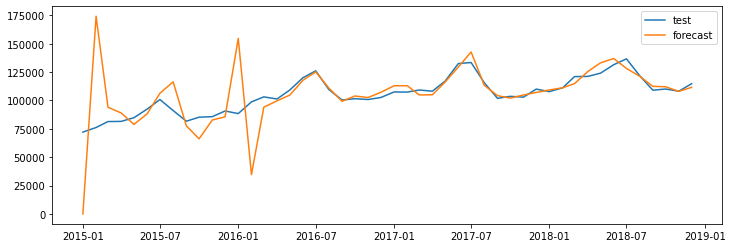

In [42]:
# Plot train vs forecast
plt.figure(figsize=(12,4))
plt.plot(train_data_boxcox_diff, label='test')
plt.plot(model.predict_in_sample(), label='forecast')
plt.legend(loc='best')
plt.show()

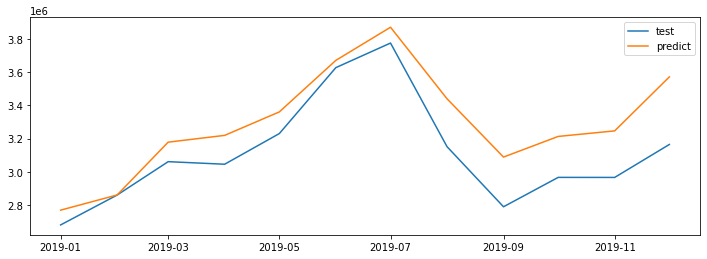

In [43]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(test['TTT'], label='test')
plt.plot(test['predict'], label='predict')
plt.legend(loc='best')
plt.show()

In [44]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(test['TTT'], test['predict'])).round(2)
mape = np.round(np.mean(np.abs(test['TTT']-test['predict'])/test['TTT'])*100,2)
tempResults = pd.DataFrame({'Method':'ARIMA with boxcox', 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,ARIMA,2.34,85731.31
0,ARIMA with boxcox,5.93,215470.54


## 3.3. Prophet

In [45]:
from prophet import Prophet

In [47]:
help(Prophet)

Help on class Prophet in module prophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
 |      flat trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selec

In [48]:
help(Prophet.fit)

Help on function fit in module prophet.forecaster:

fit(self, df, **kwargs)
    Fit the Prophet model.
    
    This sets self.params to contain the fitted model parameters. It is a
    dictionary parameter names as keys and the following items:
        k (Mx1 array): M posterior samples of the initial slope.
        m (Mx1 array): The initial intercept.
        delta (MxN array): The slope change at each of N changepoints.
        beta (MxK matrix): Coefficients for K seasonality features.
        sigma_obs (Mx1 array): Noise level.
    Note that M=1 if MAP estimation.
    
    Parameters
    ----------
    df: pd.DataFrame containing the history. Must have columns ds (date
        type) and y, the time series. If self.growth is 'logistic', then
        df must also have a column cap that specifies the capacity at
        each ds.
    kwargs: Additional arguments passed to the optimizing or sampling
        functions in Stan.
    
    Returns
    -------
    The fitted Prophet object.